In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

import medmnist
from medmnist import INFO, Evaluator

# Data Preparation

In [ ]:
print(medmnist.__version__)
# note there is also mednist+!!

3.0.2


In [ ]:
from medmnist import BreastMNIST

train_dataset = BreastMNIST(split='train', download=True)
test_dataset  = BreastMNIST(split='test', download=True)

Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz


In [ ]:
train_dataset

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /Users/ramonwinkler/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

In [ ]:
print(type(train_dataset))

<class 'medmnist.dataset.BreastMNIST'>


In [ ]:
train_dataset.info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

Note: normal + benign are combined into one class: benign!

In [ ]:
print(len(train_dataset))

546


## Convert medmnist datset object into pandas dataframe

In [ ]:
# save images and labels in a list
images = []
labels = []

for img, label in train_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [ ]:
# create a df of the extracted data
train_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [ ]:
train_df.head()

,image,label
0,"[[139, 139, 138, 139, 142, 149, 156, 159, 164,...",1
1,"[[82, 85, 83, 78, 76, 76, 79, 79, 76, 80, 86, ...",1
2,"[[157, 155, 151, 145, 149, 146, 141, 134, 141,...",1
3,"[[167, 163, 162, 151, 145, 133, 139, 149, 150,...",1
4,"[[1, 6, 41, 79, 159, 180, 175, 175, 175, 181, ...",0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   546 non-null    object
 1   label   546 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [ ]:
train_df["label"].value_counts()

label
1    399
0    147
Name: count, dtype: int64

imbalance!

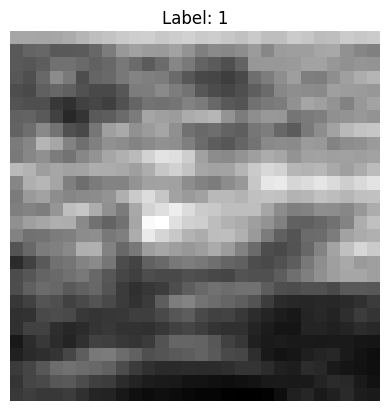

In [ ]:
# define a sample
sample = train_df.iloc[0]

img_np = sample["image"] 
label  = sample["label"]

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [ ]:
print("shape:",img_np.shape)

shape: (28, 28)


image is an np.array

## Define a simple classical CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        """
        Define the layers of the convolutional neural network.

        Parameters:
            in_channels: int
                The number of channels in the input image. For MNIST, this is 1 (grayscale images).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

In [ ]:
# device definition: gpu/ cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
# define hyperparameters
n_channels = n_channels = 1 # images are grayscale: each pixel has 1 channel!
nput_size = 784  # 28x28 pixels 
num_classes = 2 # define the number of classes (benign, malignant)
learning_rate = 0.001 # artificial, think about adjusting!
batch_size = 64
num_epochs = 500

In [ ]:
class CNN(nn.Module):
    """Classical CNN for baseline comparison - adapted for BreastMNIST."""
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8,
                               kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,
                               kernel_size=3, stride=1, padding=1)
        # After two poolings, 28 -> 7
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [ ]:
# create an instance of the cnn class
model = CNN(in_channels=n_channels)

In [ ]:
# define loss strategy and optimizer
criterion = nn.CrossEntropyLoss()
    
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # adam optimizes model.parameters!

## Transform training data to torch tensors for CNN input

In [ ]:
# extract features (pixels) and labels 
X_train = np.stack(train_df['image'].values)
y_train = np.array(train_df['label'].values)

print(X_train.shape)
print(y_train.shape)

(546, 28, 28)
(546,)


In [ ]:
# convert X,y into torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

print(X_tensor.shape)
print(y_tensor.shape)

torch.Size([546, 1, 28, 28])
torch.Size([546])


In [ ]:
num_samples = X_tensor.shape[0]

## Training

In [ ]:
# define the tracking lists
train_losses = []
train_accuracies = []
train_roc_aucs = []

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # Shuffle indices each epoch
    perm = torch.randperm(num_samples)

    for i in range(0, num_samples, batch_size):
        indices = perm[i:i+batch_size]
        data = X_tensor[indices]      # shape (batch_size, 1, 28, 28)
        targets = y_tensor[indices]   # shape (batch_size,)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch [1/500]
Epoch [2/500]
Epoch [3/500]
Epoch [4/500]
Epoch [5/500]
Epoch [6/500]
Epoch [7/500]
Epoch [8/500]
Epoch [9/500]
Epoch [10/500]
Epoch [11/500]
Epoch [12/500]
Epoch [13/500]
Epoch [14/500]
Epoch [15/500]
Epoch [16/500]
Epoch [17/500]
Epoch [18/500]
Epoch [19/500]
Epoch [20/500]
Epoch [21/500]
Epoch [22/500]
Epoch [23/500]
Epoch [24/500]
Epoch [25/500]
Epoch [26/500]
Epoch [27/500]
Epoch [28/500]
Epoch [29/500]
Epoch [30/500]
Epoch [31/500]
Epoch [32/500]
Epoch [33/500]
Epoch [34/500]
Epoch [35/500]
Epoch [36/500]
Epoch [37/500]
Epoch [38/500]
Epoch [39/500]
Epoch [40/500]
Epoch [41/500]
Epoch [42/500]
Epoch [43/500]
Epoch [44/500]
Epoch [45/500]
Epoch [46/500]
Epoch [47/500]
Epoch [48/500]
Epoch [49/500]
Epoch [50/500]
Epoch [51/500]
Epoch [52/500]
Epoch [53/500]
Epoch [54/500]
Epoch [55/500]
Epoch [56/500]
Epoch [57/500]
Epoch [58/500]
Epoch [59/500]
Epoch [60/500]
Epoch [61/500]
Epoch [62/500]
Epoch [63/500]
Epoch [64/500]
Epoch [65/500]
Epoch [66/500]
Epoch [67/500]
Epoc

## Agnostics

In [ ]:
# Make predictions on the full training set
with torch.no_grad():
    scores = model(X_tensor)                   # (num_samples, num_classes)
    probs = torch.softmax(scores, dim=1)[:, 1] # probability of class 1
    preds = torch.argmax(scores, dim=1)       # predicted labels

# Convert to numpy for sklearn
all_labels = y_tensor.cpu().numpy()
all_preds = preds.cpu().numpy()
all_probs = probs.cpu().numpy()

# Compute metrics
from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f"Train Accuracy: {acc:.4f}")
print(f"Train ROC-AUC: {roc_auc:.4f}")

Train Accuracy: 1.0000
Train ROC-AUC: 1.0000


In [ ]:
# save images and labels in a list
images = []
labels = []

for img, label in test_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [ ]:
# create a df of the extracted data
test_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [ ]:
# extract features (pixels) and labels 
X_test = np.stack(test_df['image'].values)
y_test = np.array(test_df['label'].values)

In [ ]:
# Assuming X_test is a numpy array of shape (num_samples, 28, 28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)


In [ ]:
# put model into eval mode
model.eval()

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
from torchviz import make_dot
import torch

model = model
x = torch.randn(1, 1, 28, 28)  # Dummy input
y = model(x)

# Create visualization
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_architecture')  # Saves as cnn_architecture.png

'cnn_architecture.png'

In [ ]:
from torchview import draw_graph
import torch

model = CNN()
model_graph = draw_graph(model, 
                         input_size=(1, 1, 28, 28),
                         expand_nested=True,
                         graph_name='CNN Architecture')
model_graph.visual_graph.render('cnn_graph', format='png')

'cnn_graph.png'

In [ ]:
with torch.no_grad():
    scores = model(X_test_tensor)            # raw logits, shape (num_samples, num_classes)
    probs = torch.softmax(scores, dim=1)     # probabilities for each class
    y_test_pred_labels = torch.argmax(scores, dim=1).cpu().numpy()  # predicted labels
    y_test_pred_probs = probs[:, 1].cpu().numpy()                   # probability of class 1


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(y_test, y_test_pred_labels)
roc_auc = roc_auc_score(y_test, y_test_pred_probs)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")


Test Accuracy: 0.8654
Test ROC-AUC: 0.8669


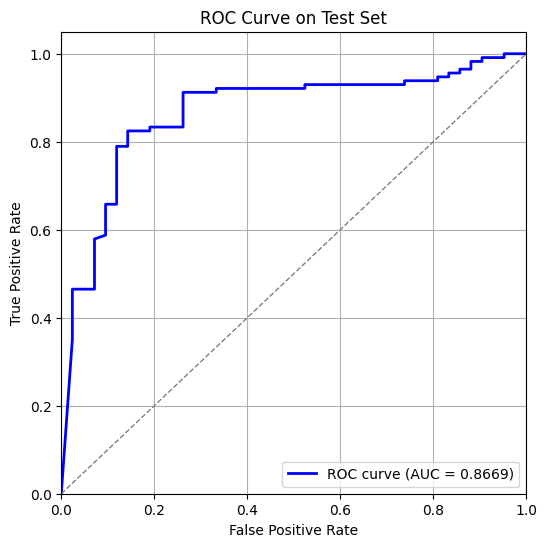

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# y_test_pred_labels: predicted labels from model
# y_test: true labels
cm = confusion_matrix(y_test, y_test_pred_labels)

print(cm)

[[ 31  11]
 [ 10 104]]


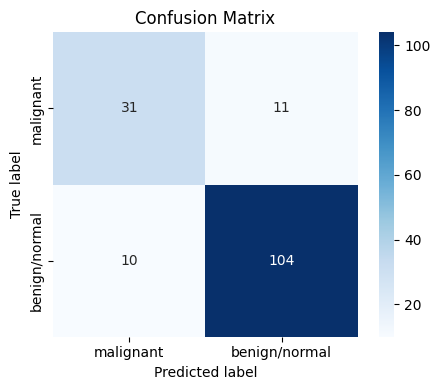

In [ ]:
class_names = ["malignant", "benign/normal"]

plt.figure(figsize=(5, 4))

    # Heatmap with counts only
sns.heatmap(
    cm, 
    annot=True,        # show numbers
    fmt="d",           # integer format
    cmap="Blues", 
    cbar=True, 
    xticklabels=class_names, 
    yticklabels=class_names,
    square=True
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, qubits, class_names=["malignant", "benign/normal"]):
    plt.figure(figsize=(5, 4))
    
    # Heatmap with counts only
    sns.heatmap(
        cm, 
        annot=True,        # show numbers
        fmt="d",           # integer format
        cmap="Blues", 
        cbar=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        square=True
    )
    
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Confusion Matrix – {qubits} qubits")
    plt.tight_layout()
    plt.show()


In [ ]:
for q, r in results.items():
    plot_confusion_matrix(r["confusion_matrix"], qubits=q)

NameError: name 'results' is not defined

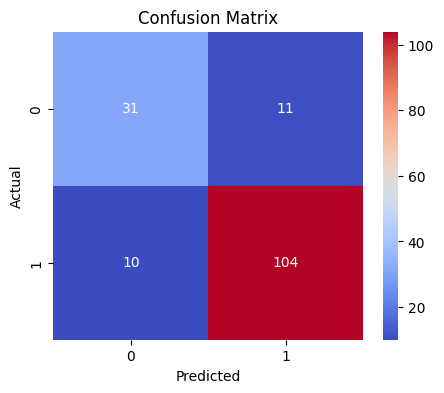

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
